<a href="https://colab.research.google.com/github/tylerscott3/CS290/blob/main/ForestFires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
pip install ucimlrepo

In [201]:
import pandas as pd
import math
import numpy as np

In [202]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
algerian_forest_fires = fetch_ucirepo(id=547)

# data (as pandas dataframes)
X = algerian_forest_fires.data.features
y = algerian_forest_fires.data.targets

# metadata
print(algerian_forest_fires.metadata)

# variable information
print(algerian_forest_fires.variables)


{'uci_id': 547, 'name': 'Algerian Forest Fires', 'repository_url': 'https://archive.ics.uci.edu/dataset/547/algerian+forest+fires+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/547/data.csv', 'abstract': 'The dataset includes 244 instances that regroup a data of two regions of Algeria.', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 244, 'num_features': 14, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Classes  '], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Mar 19 2024', 'dataset_doi': '10.24432/C5KW4N', 'creators': [' Faroudja Abid'], 'intro_paper': {'ID': 325, 'type': 'NATIVE', 'title': ' Predicting Forest Fire in Algeria Using Data Mining Techniques: Case Study of the Decision Tree Algorithm', 'authors': 'Faroudja Abid, N.Izeboudjen', 'venue': 'Ezziyyani M. (eds) Advanced Intelligent Systems

In [203]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       244 non-null    object 
 1   day          244 non-null    int64  
 2   month        244 non-null    int64  
 3   year         244 non-null    int64  
 4   Temperature  244 non-null    int64  
 5    RH          244 non-null    int64  
 6    Ws          244 non-null    int64  
 7   Rain         244 non-null    float64
 8   FFMC         244 non-null    float64
 9   DMC          244 non-null    float64
 10  DC           244 non-null    object 
 11  ISI          244 non-null    float64
 12  BUI          244 non-null    float64
 13  FWI          244 non-null    object 
dtypes: float64(5), int64(6), object(3)
memory usage: 26.8+ KB


In [204]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Classes    243 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


In [205]:

df = pd.concat([X,y], axis=1)

dfused = ['region', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'month', "Classes  "]
DFused = df[dfused]

In [206]:
DFused.head()

,region,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,month,Classes
0,Bejaia,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,6,not fire
1,Bejaia,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,6,not fire
2,Bejaia,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,6,not fire
3,Bejaia,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,6,not fire
4,Bejaia,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,6,not fire


In [207]:
DFused.nunique()

,0
region,2
Temperature,19
RH,62
Ws,18
Rain,39
FFMC,173
DMC,166
DC,198
ISI,106
BUI,174


In [208]:
DFused.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       244 non-null    object 
 1   Temperature  244 non-null    int64  
 2    RH          244 non-null    int64  
 3    Ws          244 non-null    int64  
 4   Rain         244 non-null    float64
 5   FFMC         244 non-null    float64
 6   DMC          244 non-null    float64
 7   DC           244 non-null    object 
 8   ISI          244 non-null    float64
 9   BUI          244 non-null    float64
 10  FWI          244 non-null    object 
 11  month        244 non-null    int64  
 12  Classes      243 non-null    object 
dtypes: float64(5), int64(4), object(4)
memory usage: 24.9+ KB


In [209]:
# Calculate the entropy for a categorical feature
def cat_var_entropy(df, target, feature):
    entropies = []  # List to store entropy values
    vals = df[feature].unique()  # Get unique values for the feature
    overall = len(df)  # Total number of rows
    for val in vals:
        entropy = 0  # Initialize entropy for each unique value
        subset_size = len(df[df[feature] == val])  # Size of subset for the current value
        weight = subset_size / overall  # Weight of the subset
        props = df[df[feature] == val][target].value_counts(normalize=True)  # Get the proportion of target values
        for p in props:
          entropy -= weight * (p * math.log2(p))  # Calculate entropy for the current value
          entropies.append(entropy)  # Append entropy value to the list
    return min(entropies)  # Return the minimum entropy value

In [210]:
# Calculate the Gini index for a categorical feature
def cat_var_gini(df, target, feature):
    ginis = []  # List to store Gini values
    vals = df[feature].unique()  # Get unique values for the feature
    overall = len(df)  # Total number of rows
    for val in vals:
        subset_size = len(df[df[feature] == val])  # Size of subset for the current value
        weight = subset_size / overall  # Weight of the subset
        props = df[df[feature] == val][target].value_counts(normalize=True)  # Get the proportion of target values
        gini = 1 - np.sum(np.square(props))  # Calculate Gini for the current value
        gini.append(weight * gini)  # Append weighted Gini value to the list
    return min(gini)  # Return the minimum Gini value

In [211]:
def numeric_entropy(df, target, feature):
    entropies = []  # List to store entropy values
    splits = []  # List to store split points
    vals = np.sort(df[feature].unique())  # Sorted unique values for the feature
    overall = len(df)  # Total number of rows
    for val in vals:
        entropy = 0  # Initialize entropy for each unique value
        # Split the data into two subsets: <= val and > val
        left = df[df[feature] <= val][[feature, target]]
        right = df[df[feature] > val][[feature, target]]

        # Calculate the entropy for the left subset
        props_left = left[target].value_counts(normalize=True)
        weight_left = len(left) / overall
        for prop in props_left:
            if prop > 0:
                entropy -= weight_left * prop * math.log2(prop)

        # Calculate the entropy for the right subset
        props_right = right[target].value_counts(normalize=True)
        weight_right = len(right) / overall
        for prop in props_right:
            if prop > 0:
                entropy -= weight_right * prop * math.log2(prop)

        entropies.append(entropy)  # Append entropy value to the list
        splits.append(val)  # Append split point to the list

    min_entropy = np.min(entropies)  # Get the minimum entropy value
    best_split = splits[np.argmin(entropies)]  # Find the corresponding split point
    return min_entropy, best_split


In [212]:
# Calculate the Gini index for a quantitative feature
def numeric_gini(df, target, feature):
    ginis = []  # List to store Gini values
    splits = []  # List to store split points
    vals = np.sort(df[feature].unique())  # Sorted unique values for the feature
    overall = len(df)  # Total number of rows
    for val in vals:
        gini = 0  # Initialize Gini index for each unique value
        # Split the data into two subsets: <= val and > val
        left = df[df[feature] <= val][[feature, target]]
        right = df[df[feature] > val][[feature, target]]

        # Calculate the Gini for the left subset
        props_left = left[target].value_counts(normalize=True)
        weight_left = len(left) / overall
        gini_left = 1 - np.sum(np.square(props_left))

        # Calculate the Gini for the right subset
        props_right = right[target].value_counts(normalize=True)
        weight_right = len(right) / overall
        gini_right = 1 - np.sum(np.square(props_right))

        # Combine Gini values and append to the list
        gini = weight_left * gini_left + weight_right * gini_right
        gini.append(gini)
        splits.append(val)

    min_gini = np.min(ginis)  # Get the minimum Gini value
    best_split = splits[np.argmin(ginis)]  # Find the corresponding split point
    return min_gini, best_split


def cat_var_check(df, feature):
    return df[feature].nunique() < 8  # A feature is considered categorical if it has fewer than 8 unique values


In [213]:
# Main attribute selection method function
def attribute_selection_method(df, target, measure):
    cat_list = []  # Store results for categorical features
    cat_feat_list = []  # Store categorical feature names
    quant_list = []  # Store results for quantitative features
    quant_feat_list = []  # Store quantitative feature names
    splits = []  # Store best split points for quantitative features
    features = df.columns.drop(target)  # Get all features except the target

    for feature in features:
        if cat_var_check(df, feature):  # If feature is categorical
            if measure == 'entropy':
                result = cat_var_entropy(df, target, feature)
            elif measure == 'gini':
                result = cat_var_gini(df, target, feature)
            cat_list.append(result)
            cat_feat_list.append(feature)
        else:  # If feature is quantitative
            if measure == 'entropy':
                min_entropy, best_split = numeric_entropy(df, target, feature)
                quant_list.append(min_entropy)
                splits.append(best_split)
            elif measure == 'gini':
                min_gini, best_split = numeric_gini(df, target, feature)
                quant_list.append(min_gini)
                splits.append(best_split)
            quant_feat_list.append(feature)

    # Determine the best feature and split point
    if cat_list and min(cat_list) <= min(quant_list):
        return cat_feat_list[np.argmin(cat_list)]
    else:
        best_index = np.argmin(quant_list)
        return quant_feat_list[best_index], splits[best_index]

In [239]:
def mean_sq_error_cat(df, target, feature):
    MSE = []
    splits = []
    vals = df[feature].unique()
    overall = len(df)

    for val in vals:
        # Split into left (matching category) and right (not matching category) subsets
        left = df[df[feature] == val][target]
        right = df[df[feature] != val][target]

        # Calculate MSE for left and right subsets
        if len(left) > 0:
            mse_left = np.mean((left - left.mean()) ** 2)
        else:
            mse_left = 0

        if len(right) > 0:
            mse_right = np.mean((right - right.mean()) ** 2)
        else:
            mse_right = 0

        # Weighted average of the MSEs
        weight_left = len(left) / overall
        weight_right = len(right) / overall
        mse = weight_left * mse_left + weight_right * mse_right

        MSE.append(mse)
        splits.append(val)

    # Return the minimum MSE value and the best category split
    min_mse = np.min(MSE)
    best_split = splits[np.argmin(MSE)]
    return min_mse, best_split

In [240]:
# Mean Squared Error for quantitative features for regression
def mean_sq_error_numeric(df, target, feature):
    MSE = []
    splits = []
    vals = np.sort(df[feature].unique())
    overall = len(df)

    for val in vals:
        # Split into left and right subsets
        left = df[df[feature] <= val][target]
        right = df[df[feature] > val][target]

        # Calculate MSE for left and right subsets
        if len(left) > 0:
            mse_left = np.mean((left - left.mean()) ** 2)
        else:
            mse_left = 0

        if len(right) > 0:
            mse_right = np.mean((right - right.mean()) ** 2)
        else:
            mse_right = 0

        # Weighted average of the MSEs
        weight_left = len(left) / overall
        weight_right = len(right) / overall
        mse = weight_left * mse_left + weight_right * mse_right

        MSE.append(mse)
        splits.append(val)

    #return the minimum mean squared errror value as well as the split at the matching index
    min_mse = np.min(MSE)
    best_split = splits[np.argmin(MSE)]
    return min_mse, best_split

In [241]:
mean_sq_error_cat(DFused, 'Rain ', "Classes  ")

(2.65049959355101, 'not fire')

In [242]:
mean_sq_error_cat(DFused, "Rain ", 'month')

(3.9215949602043234, 9)

In [243]:
def reg_selection(df, target):
    cat_list = []  # Store results for categorical features
    cat_feat_list = []  # Store categorical feature names
    quant_list = []  # Store results for quantitative features
    quant_feat_list = []  # Store quantitative feature names
    splits = []  # Store best split points for quantitative features
    features = df.columns.drop(target)  # Get all features except the target

    for feature in features:
        if cat_var_check(df, feature):  # If feature is categorical
            min_mse, _ = mean_sq_error_cat(df, target, feature)
            cat_list.append(min_mse)
            cat_feat_list.append(feature)

        elif not cat_var_check(df, feature):  # If feature is quantitative
            min_mse, best_split = mean_sq_error_numeric(df, target, feature)
            quant_list.append(min_mse)
            quant_feat_list.append(feature)
            splits.append(best_split)


     # Determine the best feature and split point
    if cat_list and min(cat_list) <= min(quant_list):
        return cat_feat_list[np.argmin(cat_list)]
    else:
        best_index = np.argmin(quant_list)
        return quant_feat_list[best_index], splits[best_index]

In [244]:
DFused.head()

,region,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,month,Classes
0,Bejaia,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,6,not fire
1,Bejaia,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,6,not fire
2,Bejaia,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,6,not fire
3,Bejaia,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,6,not fire
4,Bejaia,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,6,not fire


In [249]:
def attribute_selection_method1(df, target, task, measure=None):
    if task == 'classification':
        return attribute_selection_method(df, target, measure)
    elif task == 'regression':
        return reg_selection(df, target)
    else:
        raise ValueError("Invalid task. Must be 'classification' or 'regression'.")

In [298]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(DFused, test_size=0.2)

X_train = train_set[['region', 'Temperature', ' RH',"Rain ", ' Ws',  'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'month']]
y_train = train_set['Temperature']
X_test = test_set[['region', 'Temperature', ' RH',"Rain ", ' Ws',  'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'month']]
y_test = test_set['Temperature']

In [299]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

In [300]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 164 to 95
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       195 non-null    object 
 1   Temperature  195 non-null    int64  
 2    RH          195 non-null    int64  
 3   Rain         195 non-null    float64
 4    Ws          195 non-null    int64  
 5   FFMC         195 non-null    float64
 6   DMC          195 non-null    float64
 7   DC           195 non-null    object 
 8   ISI          195 non-null    float64
 9   BUI          195 non-null    float64
 10  FWI          195 non-null    object 
 11  month        195 non-null    int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 19.8+ KB


In [301]:
num_attributes = X_train.select_dtypes(include = ['float64']).columns
cat_attributes = X_train.select_dtypes(include = ['object']).columns

trf = [ ('num', StandardScaler(), num_attributes),
       ('cat', OneHotEncoder( handle_unknown='ignore'), cat_attributes) ]
col_transform = ColumnTransformer( transformers = trf )
reg_pipeline = Pipeline( steps = [('pre', col_transform),
 ('clf', DecisionTreeRegressor(max_depth=3))])

In [302]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer # import SimpleImputer for handling missing values
from sklearn.preprocessing import LabelEncoder # import LabelEncoder for encoding target variable

# ... (Your existing code for train_test_split and data preparation) ...

# Modify the pipeline to include imputation and encoding
num_attributes = X_train.select_dtypes(include=['float64']).columns
cat_attributes = X_train.select_dtypes(include=['object']).columns

# Create pipelines for numerical and categorical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing numerical values with median
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with most frequent
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_attributes),
        ('cat', cat_pipeline, cat_attributes),
    ])

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
# Fit on both train and test data to ensure all labels are captured
label_encoder.fit(pd.concat([y_train, y_test]))
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train = y_train.fillna(y_train.mode()[0])

# Impute missing values in y_train before encoding if needed
# Assuming 'y_train' is a pandas Series or DataFrame
# y_train = y_train.fillna(y_train.median())  # Replace NaN with median, or another suitable strategy

# Create the final pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=3)),
])

# Perform cross-validation
cv_scores = cross_val_score(reg_pipeline, X_train, y_train_encoded, cv=5, scoring='neg_mean_squared_error')  # Use encoded y_train
cv_scores

array([ -6.50390446,  -6.49204706,  -5.39703323, -10.40809586,
        -6.67622756])

In [303]:
mse_scores = -cv_scores
mse_scores

array([ 6.50390446,  6.49204706,  5.39703323, 10.40809586,  6.67622756])

In [304]:
reg_pipeline.fit(X_train, y_train)
reg_predictions = reg_pipeline.predict(X_test)

In [305]:
class_pipeline.fit(X_train, y_train)
class_predictions = class_pipeline.predict(X_test)

[Text(0.5, 0.875, 'x[1] <= -0.341\nsquared_error = 13.924\nsamples = 195\nvalue = 32.303'),
 Text(0.25, 0.625, 'x[1] <= -1.687\nsquared_error = 6.975\nsamples = 52\nvalue = 28.577'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[126] <= 0.5\nsquared_error = 4.914\nsamples = 18\nvalue = 26.556'),
 Text(0.0625, 0.125, 'squared_error = 2.609\nsamples = 16\nvalue = 27.125'),
 Text(0.1875, 0.125, 'squared_error = 0.0\nsamples = 2\nvalue = 22.0'),
 Text(0.375, 0.375, 'x[0] <= -0.233\nsquared_error = 4.758\nsamples = 34\nvalue = 29.647'),
 Text(0.3125, 0.125, 'squared_error = 2.876\nsamples = 11\nvalue = 28.182'),
 Text(0.4375, 0.125, 'squared_error = 4.14\nsamples = 23\nvalue = 30.348'),
 Text(0.75, 0.625, 'x[3] <= 0.686\nsquared_error = 9.568\nsamples = 143\nvalue = 33.657'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[0] <= -0.281\nsquared_error = 7.859\nsamples = 97\nvalue = 32.701'),
 Text(0.5625, 0.125, 'squared_error = 7.026\nsamples = 74\nvalue = 31.973'),
 Text(0.687

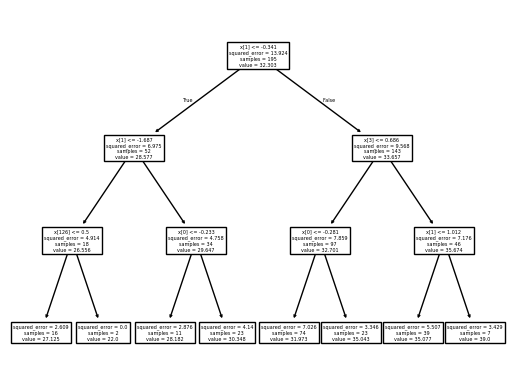

In [308]:
plot_tree(reg_pipeline.named_steps['regressor'])

[Text(0.4583333333333333, 0.875, 'x[4] <= -0.073\ngini = 0.921\nsamples = 195\nvalue = [2, 2, 4, 4, 6, 15, 13, 17, 20, 12, 20, 18, 23\n18, 9, 2, 6, 3, 1]'),
 Text(0.25, 0.625, 'x[133] <= 0.5\ngini = 0.915\nsamples = 116\nvalue = [2, 2, 4, 3, 6, 14, 12, 16, 12, 9, 11, 9, 6\n2, 2, 2, 3, 1, 0]'),
 Text(0.35416666666666663, 0.75, 'True  '),
 Text(0.16666666666666666, 0.375, 'x[130] <= 0.5\ngini = 0.917\nsamples = 112\nvalue = [2, 2, 4, 3, 6, 14, 12, 12, 12, 9, 11, 9, 6\n2, 2, 2, 3, 1, 0]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.914\nsamples = 109\nvalue = [2, 2, 1, 3, 6, 14, 12, 12, 12, 9, 11, 9, 6\n2, 2, 2, 3, 1, 0]'),
 Text(0.25, 0.125, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0]'),
 Text(0.3333333333333333, 0.375, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0\n0, 0, 0, 0, 0]'),
 Text(0.6666666666666666, 0.625, 'x[3] <= 0.674\ngini = 0.864\nsamples = 79\nvalue = [0, 0, 0, 1, 0, 1, 1, 1, 8, 3, 9, 9, 17, 16

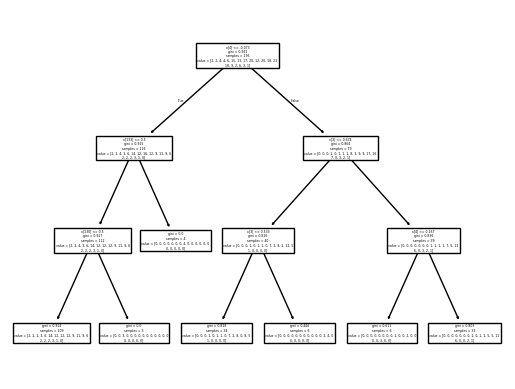

In [309]:
plot_tree(class_pipeline.named_steps['clf'])

In [ ]:
#this just removes spaces so that all the fires, not fires, and nan are the space due to spacing.
df["Classes  "] = df["Classes  "].str.strip()

In [ ]:
df["Classes  "].unique()

In [ ]:
target = "Classes  "
attribute = "Rain "

In [ ]:
vals = df[attribute].unique()
vals


In [ ]:
props = df[ df[attribute] == vals[0] ][target].value_counts( normalize=True )
props

In [ ]:
entropy = 0
for p in props.array:
  entropy = entropy - p*math.log2(p)
entropy

In [ ]:
entropy = 0
for i in range(len(props)):
  entropy = entropy - props.iloc[i]*math.log2( props.iloc[i] )
entropy

In [ ]:
entropy = 0
overall = len( df )
for val in vals:
  subset_size = len(df[ df[attribute] == val ])
  weight = subset_size / overall
  props = df[ df[attribute] == val ][target].value_counts( normalize=True )
  for p in props.array:
    entropy =  entropy - weight*(p*math.log2(p))

entropy

In [ ]:
vals.sort()
vals

In [ ]:
print(features)

In [ ]:
#df['FWI'] = pd.to_numeric(df['FWI'], errors='coerce')
overall = len( df )
entropies = []
for feature in features:
  vals = df[ feature ].unique()
  vals.sort()
  for val in vals:
    entropy = 0
    left = df[ df[feature] <= val ][ [feature,target] ]
    props = left[ target ].value_counts( normalize = True )
    weight = len( left ) / overall
    for prop in props.array:
      entropy = entropy - weight*prop*math.log2( prop )
    right = df[ df[feature] > val ][ [feature,target] ]
    props = right[ target ].value_counts( normalize = True )
    weight = len( right ) / overall
    for prop in props.array:
      entropy = entropy - weight*prop*math.log2( prop )
  entropies.append(entropy)


In [ ]:
entropy

In [ ]:
pd.Series( entropies ).idxmin()

In [ ]:
entropies[1]

In [ ]:
entropies

In [ ]:
vals[21]